In [1]:
# Common imports y set up de cada notebook

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import statsmodels.api as sm
from datetime import datetime
import time
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator

# Para imprimir objetos grandes
#np.set_printoptions(threshold = np.inf)

# Para mantener los resultados constantes al ejecutar
np.random.seed(42) # Un random.seed constante

# Para graficar figuras bonitas
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

mpl.rcParams["figure.figsize"] = (12,6.75)
mpl.rcParams["axes.grid"] = False


# Guardar/importar imágenes

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Guardar/importar datos
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(DATA_PATH, exist_ok=True)

# Guardar datasets
DATASETS = os.path.join(PROJECT_ROOT_DIR, "datasets")
os.makedirs(DATASETS, exist_ok=True)

# Guardar modelos
MODELS = os.path.join(PROJECT_ROOT_DIR, "modelos")
os.makedirs(MODELS, exist_ok=True)

# Funciones 

In [2]:
def plot_real_vs_predicted(Y_real, Y_predicted, x_limits = (0,-1), savefig = False,
                           figname = "figure", formato = "png"):
    
    name = figname + "." + formato
    
    plt.figure(figsize = (12.8,7.2))
    
    y_limits = (Y_real.min(), Y_real.max())
    plt.ylim(y_limits)
    
    plt.plot(Y_real[x_limits[0]:x_limits[-1]], color = "black", linestyle = "-", linewidth=2.5, label="Real"), # color = "darkorange",
    plt.plot(Y_predicted[x_limits[0]:x_limits[-1]], "r.-", linewidth=2.3, label="Predicción")
    plt.legend(loc = 1, fontsize=17)   
    plt.xlabel("Tiempo (1 h)", fontsize=14) 
    plt.ylabel("Comsumo (normalizado)", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
def plot_learning_curves(loss, val_loss, errores, savefig = False, figname = "figure", formato = "png"):
    plt.figure(figsize = (14, 7))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", linewidth=2, label="Entrenamiento")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", linewidth=2, label="Validación")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.title("Entrenamiento: "+("{:.4e}".format(errores[0]))+", Validación: "+("{:.4e}".format(errores[-1])),
              fontsize=18)
    plt.legend(loc = 1, fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    plt.ylabel("mse", fontsize=20)
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    name = figname + "." + formato
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
    plt.show() 

def plot_train_vs_val(train_errors, val_errors, batch_size, errores, figure_size = (14,7), savefig = False, 
                            figname = "figure", formato = "png"):
        
    name = figname + "." + formato
    
    plt.figure(figsize = figure_size)

    y_limits = (np.min([train_errors.min(), val_errors.min()]), np.max([train_errors.max(), val_errors.max()]))
    plt.ylim(y_limits)
       
   
    plt.title("Entrenamiento: "+("{:.4e}".format(errores[0]))+", Validación: "+("{:.4e}".format(errores[-1])),
              fontsize=18)
    plt.plot(train_errors,  "b.-", linewidth=2, label="Entrenamiento"), # color = "darkorange",
    plt.plot(val_errors, "r.-", linewidth=2, label="Validación")
    plt.legend(loc = 1, fontsize=20)   
    plt.xlabel("Tamaño del conjunto de entrenamiento / "+str(batch_size), fontsize=20) 
    plt.ylabel("mse", fontsize=20)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
    
def ts_learning_curves(model, X_train, Y_train, X_val, Y_val, batch = 1):
    
    # Esta función ENTRENA un modelo de ML y muestra sus Learning curves.
        
    train_errors, val_errors = [], []
    print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
    
    start_time = time.time()
    
    iteraciones = Y_train.shape[0]
    
    for i in range(0, iteraciones, batch):
        
        index = i+1    
        if (index + 1) > iteraciones:
            break
            
        X_train_slice, Y_train_slice = X_train[:index], Y_train[:index]
        
        model.fit(X_train_slice, Y_train_slice)
            
        Y_train_slice_predicted = model.predict(X_train_slice)
        Y_val_predicted = model.predict(X_val)
        
        train_errors.append(mean_squared_error(Y_train_slice, Y_train_slice_predicted))
        val_errors.append(mean_squared_error(Y_val, Y_val_predicted))
        
        current_time = time.time()
    
        if i%100 == 0: # Notificación para ver cuánto tiempo de entrenamiento lleva, y cuánto queda.
            print("training: "+str(i)+" of "+str(iteraciones), "current time: "+str(current_time - start_time) + " s")

    execution_time = time.time() - start_time
    

        
    print("tiempo de ejecución: "+str(execution_time)+" s")
    
    history = pd.DataFrame()
    history["loss"] = train_errors
    history["val_loss"] = val_errors
    
    return history
    
    
def plot_hours(real, predicted, targets = 1, bloques = 12):
    
    Y_real = []
    Y_predicted = []
    
    a = 0
    for i in range(0, targets*bloques, bloques):
        
        Y_real.extend(real[i])
        Y_predicted.extend(predicted[i])
         
    plt.figure(figsize = (12, 6.75))
    plt.plot(Y_real, color = "black", linestyle = "-", linewidth=2, label="Real")
    plt.plot(Y_predicted,  "r.-", linewidth=2, label="Predicted")
    plt.legend(loc = 1, fontsize=14)    
    plt.xlabel("Time (1 h)", fontsize=14) 
    plt.ylabel("Consumption (normalized)", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    plt.show()

# Importo los datos

In [3]:
df_train = pd.read_csv(os.path.join(DATASETS, "df_train.csv"))
df_test = pd.read_csv(os.path.join(DATASETS, "df_test.csv"))

formato = '%Y-%m-%d %H'

df_train['Datetime'] = pd.to_datetime(df_train["Datetime"], format=formato, utc = True)
df_train = df_train.set_index(pd.DatetimeIndex(df_train['Datetime']))
df_train.drop(["Datetime"], axis = "columns", inplace = True)

df_test['Datetime'] = pd.to_datetime(df_test["Datetime"], format=formato, utc = True)
df_test = df_test.set_index(pd.DatetimeIndex(df_test['Datetime']))
df_test.drop(["Datetime"], axis = "columns", inplace = True)

useful_features = df_train.columns.to_list()
print(df_train.shape, df_train.columns, "\n")
print(df_test.shape, df_test.columns, "\n")
print(df_train.index.min(), df_train.index.max(), df_test.index.min(), df_test.index.max())

(28051, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y + 11',
       'y + 12', 'y + 13', 'y + 14', 'y + 15', 'y + 16', 'y + 17', 'y + 18',
       'y + 19', 'y + 20', 'y + 21', 'y + 22', 'y + 23', 'y + 24'],
      dtype='object') 

(7013, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y +

# Preparación de los datasets

In [4]:
# Selecciono las columnas para one step forecasting

df_train = df_train.iloc[:,:-24].dropna()
df_test = df_test.iloc[:,:-24].dropna()

In [5]:
X_Y_train = df_train.to_numpy()

X_Y_test = df_test.to_numpy()
X_test = X_Y_test[:,:]
Y_test = X_Y_test[:,-1]

In [6]:
# Hago la división en train y val

from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Hacer train_test_split con shuffle = False y random_state = cte sirve para dividir time series

X_train, X_val, Y_train, Y_val = train_test_split(X_Y_train[:,:], X_Y_train[:,-1],
                                                  test_size = 0.25, random_state = 42, shuffle = False)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

(21038, 14) (21038,) (7013, 14) (7013,) (7013, 14) (7013,)


In [7]:
# Escalo la data a un rango [0, 1]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_Y_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train)], axis = 1)
#X_Y_train = np.concatenate([X_train, np.expand_dims(Y_train, axis=1)], axis = 1)
X_Y_train = scaler.fit_transform(X_Y_train)

X_Y_val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(Y_val)], axis = 1)
#X_Y_val = np.concatenate([X_val, np.expand_dims(Y_val, axis=1)], axis = 1)
X_Y_val = scaler.transform(X_Y_val)

X_Y_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(Y_test)], axis = 1)
#X_Y_test = np.concatenate([X_test, np.expand_dims(Y_test, axis=1)], axis = 1)
X_Y_test = scaler.transform(X_Y_test)

In [8]:
# Lo convierto en un problema de ML

win_len = 1             # Intento predecir el siguiente instante en el consumo con 1 h de antelación
tamaño_del_batch = 256
number_of_features = 14

# series

train_ts_generator = TimeseriesGenerator(X_Y_train[:,:-1], X_Y_train[:,-1], length = win_len, sampling_rate = 1,
                                         batch_size = tamaño_del_batch, stride = 1)

val_ts_generator = TimeseriesGenerator(X_Y_val[:,:-1], X_Y_val[:,-1], length = win_len, sampling_rate = 1,
                                       batch_size = tamaño_del_batch, stride = 1)

test_ts_generator = TimeseriesGenerator(X_Y_test[:,:-1], X_Y_test[:,-1], length = win_len, sampling_rate = 1,
                                         batch_size = tamaño_del_batch, stride = 1)


# length es el tamaño de la ventana
# sampling_rate es cada cuánto consideramos un dato (1 para datos continuos)
# stride es la separación entre una muestra de train y la siguiente 


print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
print(train_ts_generator[0][0].shape, train_ts_generator[0][1].shape)

(21038, 14) (21038,) (7013, 14) (7013,)
(256, 1, 14) (256,)


# Modelos de base & tabla de errores

In [9]:
# mi modelo de base va a ser naive forecasting. "El consumo de ahora es el mismo que el del instante anterior"

# función auxiliar

def baseline_model_1(samples, previous_sample=1): # cualquier instante anterior
    
    # Samples es un dataframe con los targets
    # previous_sample es la muestra anterior que queremos que se devuelva
    
    df = pd.DataFrame(data = samples, columns = ["real"])
    if previous_sample > samples.size:
        return ("No hay instantes anteriores a t-"+str(previous_sample))
    
    df["naive_1h"] = df["real"].shift(previous_sample)
    
    return df.dropna()


# Creo la predicción del modelo naive en los tres sets

# train, val, test

naive_train = baseline_model_1(Y_train, previous_sample=1)
naive_val = baseline_model_1(Y_val, previous_sample=1)
naive_test = baseline_model_1(Y_test, previous_sample=1)

# creo un dataframe para guardar los errores
from sklearn.metrics import mean_squared_error

errores_df = pd.DataFrame()

errores_df.loc["naive_1h", "train mse"] = mean_squared_error(naive_train.iloc[:,0], naive_train.iloc[:,-1])
errores_df.loc["naive_1h", "val mse"] = mean_squared_error(naive_val.iloc[:,0], naive_val.iloc[:,-1])
errores_df.loc["naive_1h", "delta errores"] = np.abs(errores_df.loc["naive_1h", "train mse"]-errores_df.loc["naive_1h", "val mse"])
errores_df.loc["naive_1h", "n params"] = 0
errores_df.loc["naive_1h", "training time (s)"] = np.nan
errores_df.loc["naive_1h", "training prediction time (s)"] = np.nan
errores_df.loc["naive_1h", "validation prediction time (s)"] = np.nan

pd.options.display.float_format = '{:.2e}'.format
#pd.options.display.float_format = '{:.7f}'.format
#pd.reset_option("all")
errores_df.sort_values(by = ["val mse"])

,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
naive_1h,2.10e+06,1.99e+06,1.04e+05,0.00e+00,nan,nan,nan


# DNN 4

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

dnn_4 = keras.models.Sequential([
    keras.layers.Input((win_len, number_of_features)),
    keras.layers.Dense(24, activation = "relu"),
    keras.layers.Dense(1, activation = "relu")                                                      
])



early_stopping = keras.callbacks.EarlyStopping(patience = 5)

dnn_4.compile(loss = "mse", optimizer = "adam")  # metrics = ["mse"])
                      
history_dnn_4 = dnn_4.fit(train_ts_generator, epochs = 500, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping])

Epoch 1/500
83/83 [==============================] - 1s 7ms/step - loss: 0.0694 - val_loss: 0.0222
Epoch 2/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0179 - val_loss: 0.0112
Epoch 3/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.0084
Epoch 4/500
83/83 [==============================] - 0s 5ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 5/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0084
Epoch 6/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0082
Epoch 7/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 0.0079
Epoch 8/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0074
Epoch 9/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0070
Epoch 10/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0066
Epoch 11/

83/83 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 84/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 85/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 86/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 87/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 88/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 89/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 90/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 91/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 92/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0016


In [ ]:
dnn_4.

In [43]:
dnn_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 24)             360       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              25        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [12]:
errores_df.loc["dnn_4", "train mse"]     = dnn_4.evaluate(train_ts_generator)
errores_df.loc["dnn_4", "val mse"]       = dnn_4.evaluate(val_ts_generator)
errores_df.loc["dnn_4", "n params"]      = dnn_4.count_params()
errores_df.loc["dnn_4", "delta errores"] = np.abs(errores_df.loc["dnn_4", "train mse"]-errores_df.loc["dnn_4", "val mse"])

errores_df.sort_values(by = ["val mse"])

28/28 [==============================] - 0s 2ms/step - loss: 0.0016


,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
dnn_4,1.73e-03,1.58e-03,1.53e-04,3.85e+02,nan,nan,nan
naive_1h,2.10e+06,1.99e+06,1.04e+05,0.00e+00,nan,nan,nan


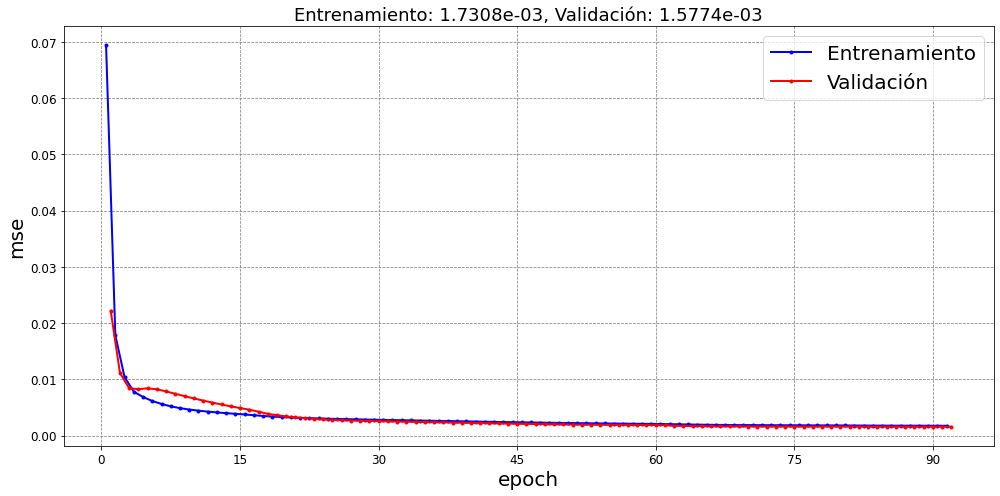

In [49]:
history_dnn_4_df = pd.DataFrame(history_dnn_4.history)


plot_learning_curves(history_dnn_4_df["loss"], history_dnn_4_df["val_loss"],
                     errores = (errores_df.loc["dnn_4", "train mse"], errores_df.loc["dnn_4", "val mse"]),
                    savefig = True, figname = "lc_dnn")

In [14]:
Y_train_dnn_4 = dnn_4.predict(train_ts_generator).flatten()
Y_val_dnn_4   = dnn_4.predict(val_ts_generator).flatten()

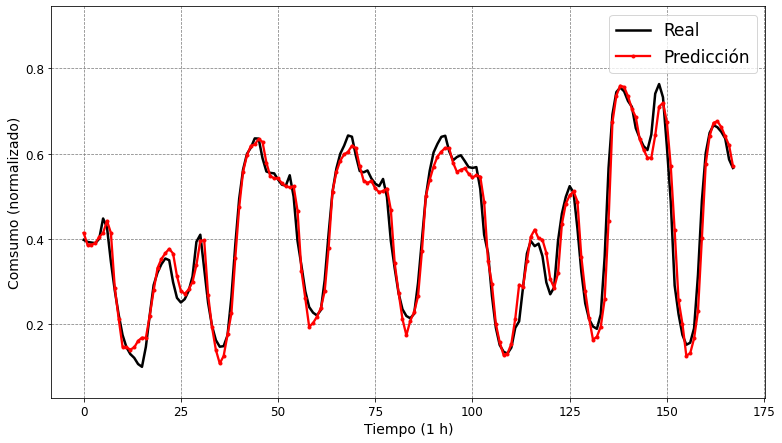

In [15]:
plot_real_vs_predicted(X_Y_val[1:,-1], Y_val_dnn_4, x_limits = (24,24*8))

# RNN 7

In [28]:
np.random.seed(42) 
tf.random.set_seed(42)

rnn_7 = keras.models.Sequential([
    keras.layers.SimpleRNN(number_of_features, input_shape = [win_len, number_of_features], activation = "relu",
                           return_sequences=True),
    keras.layers.SimpleRNN(10, input_shape = [win_len, number_of_features], activation = "relu",
                           return_sequences=True),
    keras.layers.SimpleRNN(10, input_shape = [win_len, number_of_features], activation = "relu",
                           return_sequences=True),
    keras.layers.SimpleRNN(7, input_shape = [win_len, number_of_features], activation = "relu",
                           return_sequences=True),
    keras.layers.SimpleRNN(1, activation = "relu")
])

#early_stopping = keras.callbacks.EarlyStopping(patience = 5)


rnn_7.compile(loss = "mse", optimizer = "adam")

history_rnn_7 = rnn_7.fit(train_ts_generator, epochs = 600, validation_data = val_ts_generator, shuffle = False,)
                          #callbacks = [early_stopping])

Epoch 1/600
83/83 [==============================] - 1s 17ms/step - loss: 0.0798 - val_loss: 0.0288
Epoch 2/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0237 - val_loss: 0.0155
Epoch 3/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0138 - val_loss: 0.0100
Epoch 4/600
83/83 [==============================] - 1s 6ms/step - loss: 0.0100 - val_loss: 0.0076
Epoch 5/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0080 - val_loss: 0.0070
Epoch 6/600
83/83 [==============================] - 1s 6ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 7/600
83/83 [==============================] - 1s 9ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 8/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0055 - val_loss: 0.0062
Epoch 9/600
83/83 [==============================] - 1s 8ms/step - loss: 0.0051 - val_loss: 0.0061
Epoch 10/600
83/83 [==============================] - 1s 8ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 11

83/83 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 84/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 85/600
83/83 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 86/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 87/600
83/83 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 88/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 89/600
83/83 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 90/600
83/83 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 91/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 92/600
83/83 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 93/600


83/83 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 9.8606e-04
Epoch 245/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 9.8572e-04
Epoch 246/600
83/83 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 9.8646e-04
Epoch 247/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 9.8599e-04
Epoch 248/600
83/83 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 9.8568e-04
Epoch 249/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 9.8452e-04
Epoch 250/600
83/83 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 9.8328e-04
Epoch 251/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 9.8284e-04
Epoch 252/600
83/83 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 9.8209e-04
Epoch 253/600
83/83 [==============================] - 1s 7ms/step - 

Epoch 400/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 9.0495e-04
Epoch 401/600
83/83 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 9.0536e-04
Epoch 402/600
83/83 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 9.0357e-04
Epoch 403/600
83/83 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 9.0442e-04
Epoch 404/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 9.0436e-04
Epoch 405/600
83/83 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 9.0429e-04
Epoch 406/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 9.0370e-04
Epoch 407/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 9.0370e-04
Epoch 408/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 9.0345e-04
Epoch 409/600
83/83 [==============================] - 

83/83 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 8.9325e-04
Epoch 479/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 8.9324e-04
Epoch 480/600
83/83 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 8.9279e-04
Epoch 481/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 8.9316e-04
Epoch 482/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 8.9408e-04
Epoch 483/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 8.9452e-04
Epoch 484/600
83/83 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 8.9388e-04
Epoch 485/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 8.9396e-04
Epoch 486/600
83/83 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 8.9373e-04
Epoch 487/600
83/83 [==============================] - 1s 8ms/step - 

83/83 [==============================] - 1s 7ms/step - loss: 9.9440e-04 - val_loss: 8.7986e-04
Epoch 556/600
83/83 [==============================] - 1s 8ms/step - loss: 9.9547e-04 - val_loss: 8.7981e-04
Epoch 557/600
83/83 [==============================] - 1s 7ms/step - loss: 9.9402e-04 - val_loss: 8.7964e-04
Epoch 558/600
83/83 [==============================] - 1s 7ms/step - loss: 9.9394e-04 - val_loss: 8.7927e-04
Epoch 559/600
83/83 [==============================] - 1s 7ms/step - loss: 9.9361e-04 - val_loss: 8.7941e-04
Epoch 560/600
83/83 [==============================] - 1s 8ms/step - loss: 9.9359e-04 - val_loss: 8.7885e-04
Epoch 561/600
83/83 [==============================] - 1s 7ms/step - loss: 9.9338e-04 - val_loss: 8.7918e-04
Epoch 562/600
83/83 [==============================] - 1s 7ms/step - loss: 9.9492e-04 - val_loss: 8.7871e-04
Epoch 563/600
83/83 [==============================] - 1s 7ms/step - loss: 9.9232e-04 - val_loss: 8.7830e-04
Epoch 564/600
83/83 [============

In [29]:
rnn_7.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 1, 14)             406       
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 1, 10)             250       
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 1, 10)             210       
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 1, 7)              126       
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 1)                 9         
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [30]:
errores_df.loc["rnn_7", "train mse"]     = rnn_7.evaluate(train_ts_generator)
errores_df.loc["rnn_7", "val mse"]       = rnn_7.evaluate(val_ts_generator)
errores_df.loc["rnn_7", "n params"]      = rnn_7.count_params()
errores_df.loc["rnn_7", "delta errores"] = np.abs(errores_df.loc["rnn_7", "train mse"]-errores_df.loc["rnn_7", "val mse"])

errores_df.sort_values(by = ["val mse"])

28/28 [==============================] - 0s 3ms/step - loss: 8.7413e-04


,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
rnn_7,9.60e-04,8.74e-04,8.54e-05,1.00e+03,nan,nan,nan
lstm_1,1.24e-03,1.08e-03,1.61e-04,6.84e+03,nan,nan,nan
dnn_4,1.73e-03,1.58e-03,1.53e-04,3.85e+02,nan,nan,nan
naive_1h,2.10e+06,1.99e+06,1.04e+05,0.00e+00,nan,nan,nan


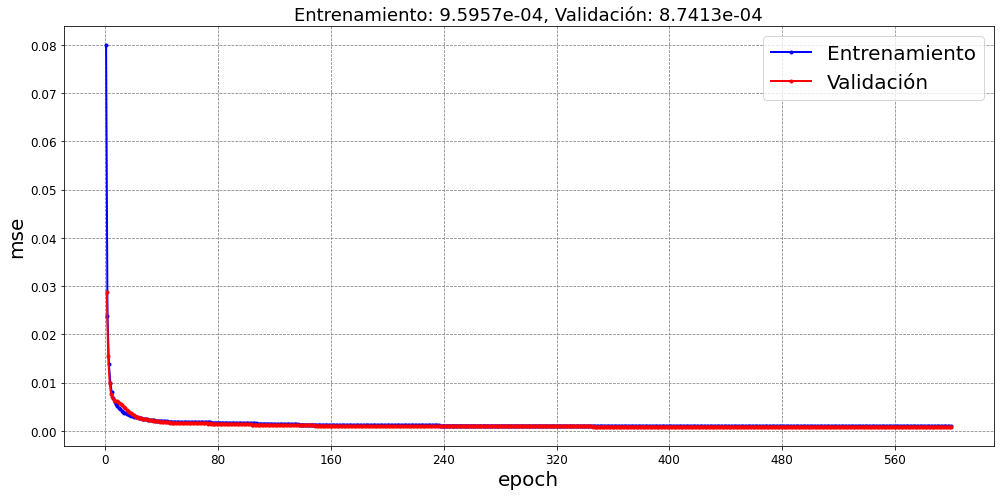

In [50]:
history_rnn_7_df = pd.DataFrame(history_rnn_7.history)

#history_rnn_7_df[["loss"]][-200:], history_rnn_7_df[["val_loss"]][-200:]
plot_learning_curves(history_rnn_7_df["loss"], history_rnn_7_df["val_loss"],
                     errores = (errores_df.loc["rnn_7", "train mse"], errores_df.loc["rnn_7", "val mse"]),
                     savefig = True, figname = "lc_rnn")

In [32]:
Y_train_rnn_7 = rnn_7.predict(train_ts_generator).flatten()
Y_val_rnn_7   = rnn_7.predict(val_ts_generator).flatten()

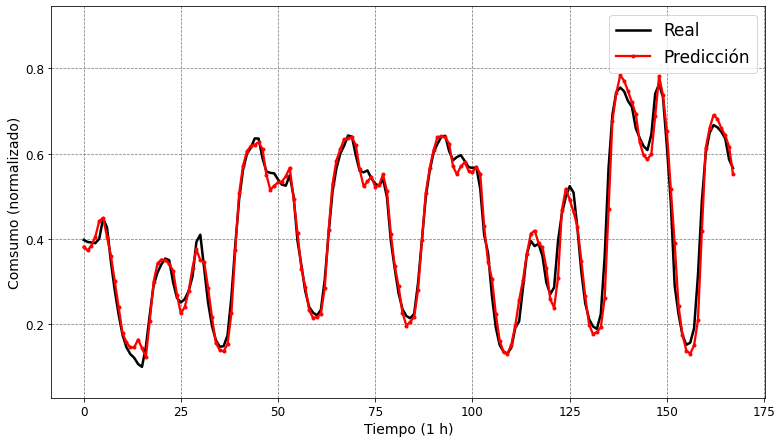

In [33]:
plot_real_vs_predicted(X_Y_val[1:,-1], Y_val_rnn_7, x_limits = (24,24*8))

# LSTM 1

In [22]:
np.random.seed(42) 
tf.random.set_seed(42)

lstm_1 = keras.models.Sequential([
    keras.layers.LSTM(20, input_shape = [win_len, number_of_features], activation = "relu",
                           return_sequences=True),
    keras.layers.LSTM(15, activation = "relu", return_sequences=True),
    keras.layers.LSTM(15, activation = "relu", return_sequences=True),
    keras.layers.Dense(1)
])

early_stopping = keras.callbacks.EarlyStopping(patience = 5)


lstm_1.compile(loss = "mse", optimizer = "adam")

history_lstm_1 = lstm_1.fit(train_ts_generator, epochs = 250, validation_data = val_ts_generator, shuffle = False,
                          callbacks = [early_stopping])

Epoch 1/250
83/83 [==============================] - 2s 22ms/step - loss: 0.1636 - val_loss: 0.0369
Epoch 2/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0275 - val_loss: 0.0150
Epoch 3/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0168 - val_loss: 0.0117
Epoch 4/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0127 - val_loss: 0.0098
Epoch 5/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0109 - val_loss: 0.0087
Epoch 6/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0098 - val_loss: 0.0079
Epoch 7/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0089 - val_loss: 0.0072
Epoch 8/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0081 - val_loss: 0.0067
Epoch 9/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0074 - val_loss: 0.0062
Epoch 10/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0058

83/83 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 163/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 164/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 165/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 166/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 167/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 168/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 169/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 170/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 171/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 0

In [23]:
lstm_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 20)             2800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 15)             2160      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 15)             1860      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1)              16        
Total params: 6,836
Trainable params: 6,836
Non-trainable params: 0
_________________________________________________________________


In [24]:
errores_df.loc["lstm_1", "train mse"]     = lstm_1.evaluate(train_ts_generator)
errores_df.loc["lstm_1", "val mse"]       = lstm_1.evaluate(val_ts_generator)
errores_df.loc["lstm_1", "n params"]      = lstm_1.count_params()
errores_df.loc["lstm_1", "delta errores"] = np.abs(errores_df.loc["lstm_1", "train mse"]-errores_df.loc["lstm_1", "val mse"])

errores_df.sort_values(by = ["val mse"])

28/28 [==============================] - 0s 5ms/step - loss: 0.0011


,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
rnn_7,1.07e-03,9.86e-04,8.30e-05,1.00e+03,nan,nan,nan
lstm_1,1.24e-03,1.08e-03,1.61e-04,6.84e+03,nan,nan,nan
dnn_4,1.73e-03,1.58e-03,1.53e-04,3.85e+02,nan,nan,nan
naive_1h,2.10e+06,1.99e+06,1.04e+05,0.00e+00,nan,nan,nan


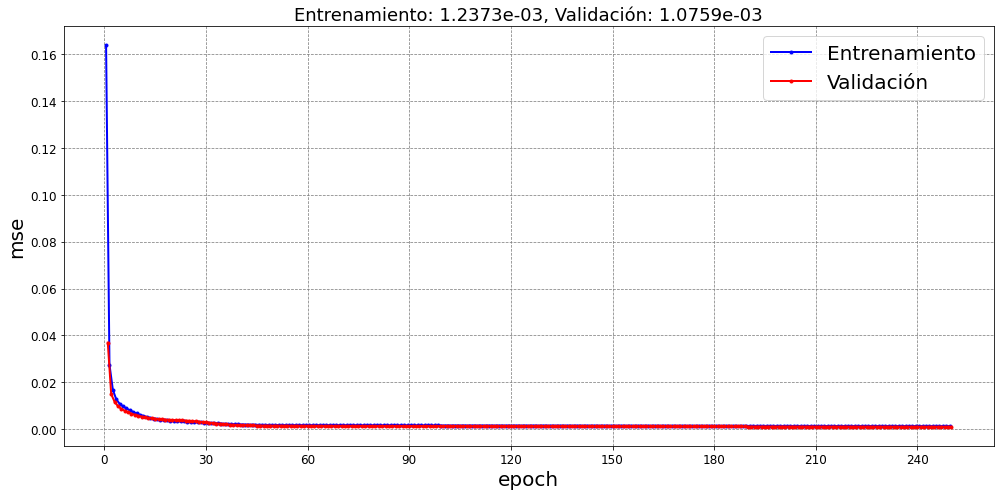

In [51]:
history_lstm_1_df = pd.DataFrame(history_lstm_1.history)

#history_lstm_1_df[["loss"]][-50:], history_lstm_1_df[["val_loss"]][-50:],
plot_learning_curves(history_lstm_1_df["loss"], history_lstm_1_df["val_loss"],
                     errores = (errores_df.loc["lstm_1", "train mse"], errores_df.loc["lstm_1", "val mse"]),
                     savefig = True, figname = "lc_lstm")

In [26]:
Y_train_lstm_1  = lstm_1.predict(train_ts_generator).flatten()
Y_val_lstm_1    = lstm_1.predict(val_ts_generator).flatten()

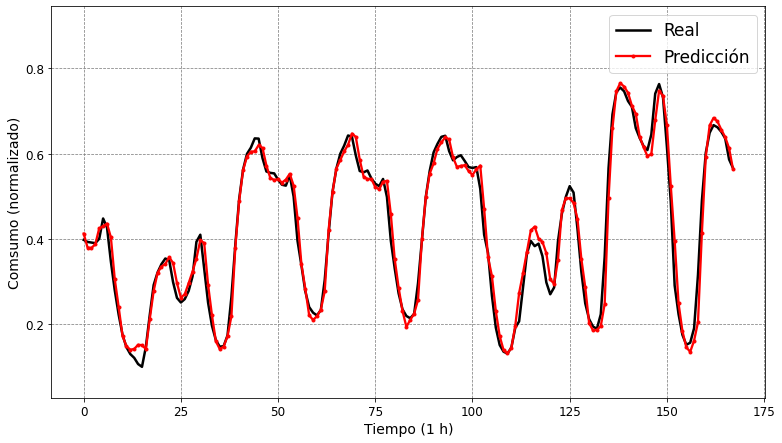

In [27]:
plot_real_vs_predicted(X_Y_val[1:,-1], Y_val_lstm_1, x_limits = (24,24*8))

In [53]:
from keras.models import load_model

path1 = os.path.join(MODELS, 'dnn.h5')
path2 = os.path.join(MODELS, 'rnn.h5')
path3 = os.path.join(MODELS, 'lstm.h5')

dnn_4.save(path1)  # creates a HDF5 file 'my_model.h5'
rnn_7.save(path2)
lstm_1.save(path3)
# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')



# GRU 1

In [16]:
np.random.seed(42) 
tf.random.set_seed(42)

gru_1 = keras.models.Sequential([
    keras.layers.GRU(20, input_shape = [win_len, number_of_features], activation = "relu",
                           return_sequences=True),
    keras.layers.GRU(15, activation = "relu", return_sequences=True),
    keras.layers.GRU(15, activation = "relu", return_sequences=True),
    keras.layers.Dense(1)
])

early_stopping = keras.callbacks.EarlyStopping(patience = 5)


gru_1.compile(loss = "mse", optimizer = "adam")

history_gru_1 = gru_1.fit(train_ts_generator, epochs = 250, validation_data = val_ts_generator, shuffle = False,
                          callbacks = [early_stopping])

Epoch 1/250
83/83 [==============================] - 2s 19ms/step - loss: 0.1029 - val_loss: 0.0234
Epoch 2/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0190 - val_loss: 0.0126
Epoch 3/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0116 - val_loss: 0.0093
Epoch 4/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0088 - val_loss: 0.0080
Epoch 5/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 6/250
83/83 [==============================] - 1s 11ms/step - loss: 0.0065 - val_loss: 0.0075
Epoch 7/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0057 - val_loss: 0.0071
Epoch 8/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0051 - val_loss: 0.0068
Epoch 9/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0046 - val_loss: 0.0063
Epoch 10/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0042 - val_loss: 0.0059

83/83 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 83/250
83/83 [==============================] - 1s 14ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 84/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 85/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 86/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 87/250
83/83 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 88/250
83/83 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 89/250
83/83 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 90/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 91/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0013
Epo

83/83 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 163/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 164/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 165/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 166/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 167/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 168/250
83/83 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 169/250
83/83 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 170/250
83/83 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 171/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0

83/83 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 9.4816e-04
Epoch 241/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 9.4979e-04
Epoch 242/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 9.4739e-04
Epoch 243/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 9.4485e-04
Epoch 244/250
83/83 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 9.4307e-04
Epoch 245/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 9.4293e-04
Epoch 246/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 9.4318e-04
Epoch 247/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 9.4158e-04
Epoch 248/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 9.3973e-04
Epoch 249/250
83/83 [==============================] - 1s 12

In [17]:
gru_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 1, 20)             2160      
_________________________________________________________________
gru_4 (GRU)                  (None, 1, 15)             1665      
_________________________________________________________________
gru_5 (GRU)                  (None, 1, 15)             1440      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              16        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [18]:
errores_df.loc["gru_1", "train mse"]     = gru_1.evaluate(train_ts_generator)
errores_df.loc["gru_1", "val mse"]       = gru_1.evaluate(val_ts_generator)
errores_df.loc["gru_1", "n params"]      = gru_1.count_params()
errores_df.loc["gru_1", "delta errores"] = np.abs(errores_df.loc["gru_1", "train mse"]-errores_df.loc["gru_1", "val mse"])

errores_df.sort_values(by = ["val mse"])

28/28 [==============================] - 0s 6ms/step - loss: 9.3793e-04


,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
gru_1,1.07e-03,9.38e-04,1.29e-04,5.28e+03,nan,nan,nan
naive_1h,2.10e+06,1.99e+06,1.04e+05,0.00e+00,nan,nan,nan


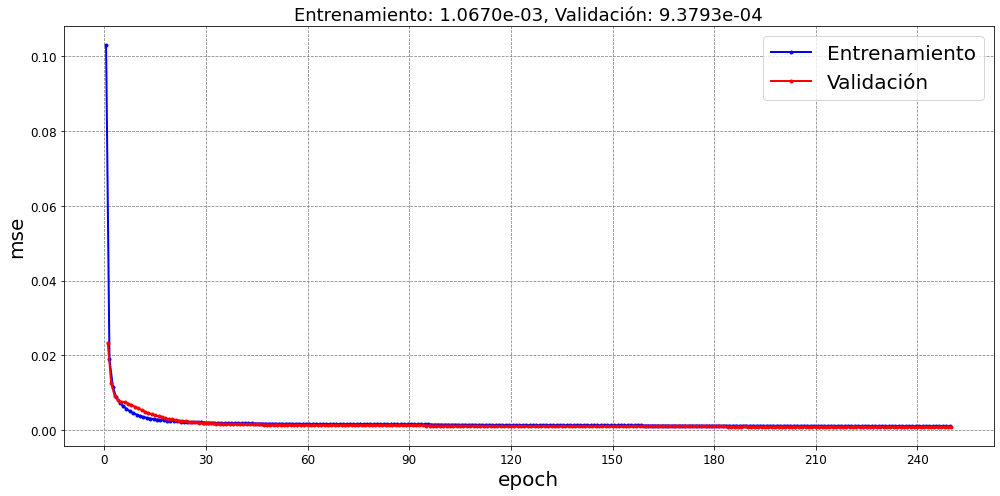

In [31]:
history_gru_1_df = pd.DataFrame(history_gru_1.history)

#history_lstm_1_df[["loss"]][-50:], history_lstm_1_df[["val_loss"]][-50:],
plot_learning_curves(history_gru_1_df["loss"], history_gru_1_df["val_loss"],
                     errores = (errores_df.loc["gru_1", "train mse"], errores_df.loc["gru_1", "val mse"]),
                     savefig = True, figname = "lc_lgru_1")

In [20]:
Y_train_gru_1  = gru_1.predict(train_ts_generator).flatten()
Y_val_gru_1    = gru_1.predict(val_ts_generator).flatten()

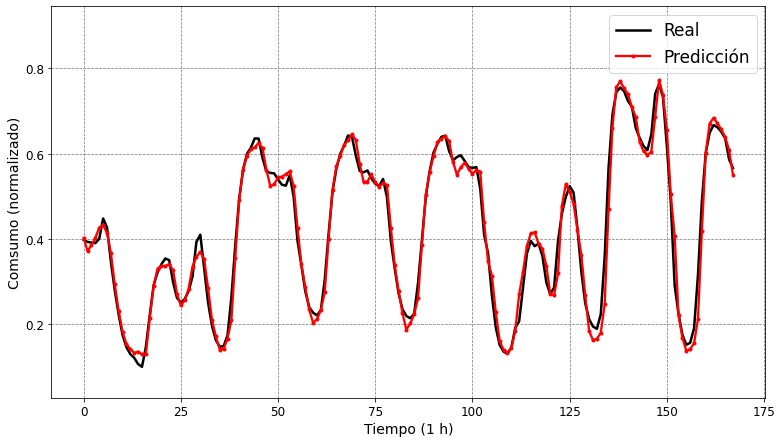

In [21]:
plot_real_vs_predicted(X_Y_val[1:,-1], Y_val_gru_1, x_limits = (24,24*8))

In [32]:
# Guardo el modelo
from keras.models import load_model

path4 = os.path.join(MODELS, 'gru.h5')

gru_1.save(path4)  # creates a HDF5 file 'my_model.h5'
# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

# GRU 2

In [24]:
np.random.seed(42) 
tf.random.set_seed(42)

gru_2 = keras.models.Sequential([
    keras.layers.GRU(number_of_features, input_shape = [win_len, number_of_features], activation = "relu",
                           return_sequences=True),
    keras.layers.GRU(10, input_shape = [win_len, number_of_features], activation = "relu",
                     return_sequences=True),
    keras.layers.GRU(10, input_shape = [win_len, number_of_features], activation = "relu",
                     return_sequences=True),
    keras.layers.GRU(7, input_shape = [win_len, number_of_features], activation = "relu",
                     return_sequences=True),
    keras.layers.GRU(1, activation = "relu")
])

#early_stopping = keras.callbacks.EarlyStopping(patience = 5)


gru_2.compile(loss = "mse", optimizer = "adam")

history_gru_2 = gru_2.fit(train_ts_generator, epochs = 250, validation_data = val_ts_generator, shuffle = False,)
                          #callbacks = [early_stopping])

Epoch 1/250
83/83 [==============================] - 2s 23ms/step - loss: 0.1451 - val_loss: 0.0259
Epoch 2/250
83/83 [==============================] - 1s 14ms/step - loss: 0.0219 - val_loss: 0.0153
Epoch 3/250
83/83 [==============================] - 1s 16ms/step - loss: 0.0164 - val_loss: 0.0125
Epoch 4/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0127 - val_loss: 0.0109
Epoch 5/250
83/83 [==============================] - 1s 14ms/step - loss: 0.0105 - val_loss: 0.0098
Epoch 6/250
83/83 [==============================] - 1s 14ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 7/250
83/83 [==============================] - 1s 10ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 8/250
83/83 [==============================] - 1s 14ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 9/250
83/83 [==============================] - 1s 14ms/step - loss: 0.0073 - val_loss: 0.0075
Epoch 10/250
83/83 [==============================] - 1s 11ms/step - loss: 0.0068 - val_loss: 0.0072

83/83 [==============================] - 1s 14ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 83/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 84/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 85/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 86/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 87/250
83/83 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 88/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 89/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 90/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 91/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0016
Epo

83/83 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 163/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 164/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 165/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 166/250
83/83 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 167/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 168/250
83/83 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 169/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 170/250
83/83 [==============================] - 1s 16ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 171/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0

83/83 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 243/250
83/83 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 244/250
83/83 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 245/250
83/83 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 246/250
83/83 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 247/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 248/250
83/83 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 249/250
83/83 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 250/250
83/83 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0011


In [25]:
gru_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 1, 14)             1260      
_________________________________________________________________
gru_7 (GRU)                  (None, 1, 10)             780       
_________________________________________________________________
gru_8 (GRU)                  (None, 1, 10)             660       
_________________________________________________________________
gru_9 (GRU)                  (None, 1, 7)              399       
_________________________________________________________________
gru_10 (GRU)                 (None, 1)                 30        
Total params: 3,129
Trainable params: 3,129
Non-trainable params: 0
_________________________________________________________________


In [26]:
errores_df.loc["gru_2", "train mse"]     = gru_2.evaluate(train_ts_generator)
errores_df.loc["gru_2", "val mse"]       = gru_2.evaluate(val_ts_generator)
errores_df.loc["gru_2", "n params"]      = gru_2.count_params()
errores_df.loc["gru_2", "delta errores"] = np.abs(errores_df.loc["gru_2", "train mse"]-errores_df.loc["gru_2", "val mse"])

errores_df.sort_values(by = ["val mse"])

28/28 [==============================] - 0s 4ms/step - loss: 0.0011


,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
gru_1,1.07e-03,9.38e-04,1.29e-04,5.28e+03,nan,nan,nan
gru_2,1.23e-03,1.06e-03,1.72e-04,3.13e+03,nan,nan,nan
naive_1h,2.10e+06,1.99e+06,1.04e+05,0.00e+00,nan,nan,nan


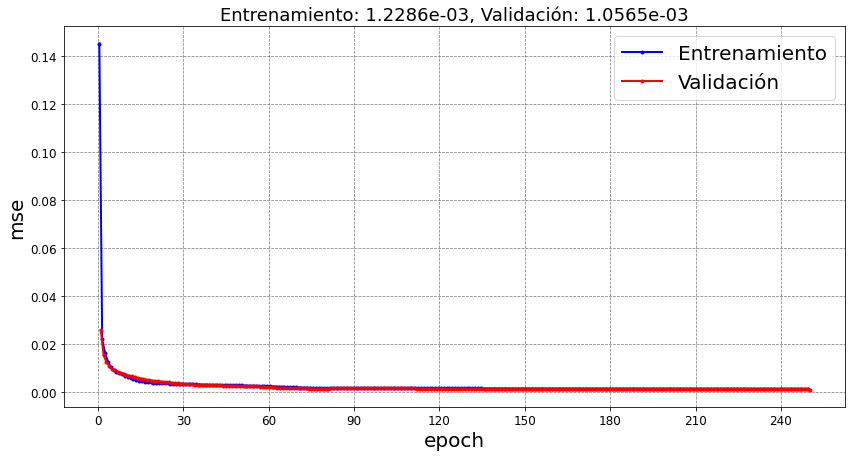

In [27]:
history_gru_2_df = pd.DataFrame(history_gru_2.history)

#history_rnn_7_df[["loss"]][-200:], history_rnn_7_df[["val_loss"]][-200:]
plot_learning_curves(history_gru_2_df["loss"], history_gru_2_df["val_loss"],
                     errores = (errores_df.loc["gru_2", "train mse"], errores_df.loc["gru_2", "val mse"]),
                     savefig = False, figname = "lc_gru_2")

In [28]:
Y_train_gru_2 = gru_2.predict(train_ts_generator).flatten()
Y_val_gru_2   = gru_2.predict(val_ts_generator).flatten()

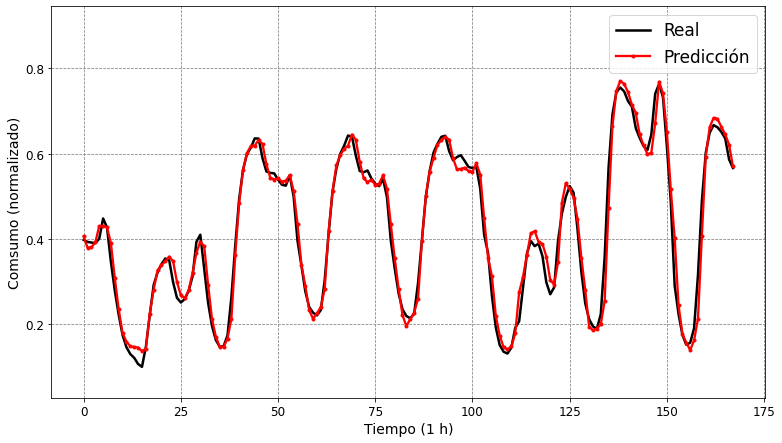

In [30]:
plot_real_vs_predicted(X_Y_val[1:,-1], Y_val_gru_2, x_limits = (24,24*8))